# Previsão com Redes Neurais Recorrentes


In [1]:
import pandas as pd
from pandas import Grouper, DataFrame

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime
import random
import time

from matplotlib import pyplot as plt
import seaborn as sns

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import pickle

import tensorflow as tf

from math import ceil

## Constantes

In [48]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 15
VAL_SPLIT_SIZE = 15
WINDOW_SIZE = 24

MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

MODEL_PATH = 'MODEL'
SCALER_FILE_NAME = os.path.join(MODEL_PATH, 'scaler.pkl')

BATCH_SIZE = 100


## Funções

In [3]:
# Returns X_train, y_train, X_valid, y_valid, X_test, y_test
def split_train_validation_test_window_dataset(full_dataset: np.ndarray, 
                                               val_percentual_size: int, 
                                               test_percentual_size: int, 
                                               window_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    dataset_size: int = full_dataset.shape[0]
    cut_pos_test: int = round(dataset_size - (dataset_size * (test_percentual_size/100)))
    cut_pos_val: int = round(cut_pos_test - (dataset_size * (val_percentual_size/100)))
    
    test_dataset_size: int = dataset_size - cut_pos_test
    val_dataset_size: int = dataset_size - cut_pos_val - test_dataset_size
    
    y_train: np.ndarray = full_dataset[window_size : cut_pos_val]
    y_val: np.ndarray = full_dataset[cut_pos_val : cut_pos_test]
    y_test: np.ndarray = full_dataset[cut_pos_test:]
    
    train_dataset_list = [full_dataset[ind : ind + window_size] for ind in range (cut_pos_val - window_size)]
    X_train = np.array(train_dataset_list)
    
    val_dataset_list = [full_dataset[cut_pos_val + ind - window_size :cut_pos_val + ind] for ind in range (val_dataset_size)]
    X_valid = np.array(val_dataset_list)
    
    test_dataset_list = [full_dataset[cut_pos_test + ind - window_size :cut_pos_test + ind] for ind in range (test_dataset_size)]
    X_test = np.array(test_dataset_list)
    
    return (X_train, y_train, X_valid, y_val, X_test, y_test)

## Carrega Datasets

In [4]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

In [5]:
scaler = MinMaxScaler()
desembolso = desembolso.reshape(-1,1)
scaler.fit(desembolso)
desembolso = scaler.transform(desembolso)
desembolso = desembolso.squeeze()

pickle.dump(scaler, open(SCALER_FILE_NAME, 'wb'))

In [6]:
(X_train, y_train, X_valid, y_valid, X_test, y_test) = split_train_validation_test_window_dataset(desembolso, VAL_SPLIT_SIZE, TEST_SPLIT_SIZE, WINDOW_SIZE)

In [7]:
n_samples = X_train.shape[0] # samples
n_timesteps = X_train.shape[1] # window_size
n_features = 1 #univariate

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
X_valid_rs = X_valid.reshape(X_valid.shape[0], n_timesteps, n_features)

---
### Univariate LSTM

In [87]:
# RNN recebe input_shape no seguinte formato
# (N,T,D), where N is the number of samples, T is length of time sequence and D is the number of features

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(n_timesteps,n_features)),
    #tf.keras.layers.LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=50,return_sequences=False)),
    #tf.keras.layers.LSTM(50, return_sequences=False),
   # tf.keras.layers.Dense(20, activation='softmax'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

lstm_model.compile(optimizer='adam', loss='mse')


In [88]:
model_univariate_path = os.path.join(MODEL_PATH, 'model-lstm-desembolso-univariate.h5')

history = lstm_model.fit(x=X_train,
                         y=y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=150,
                         shuffle=False,
                         batch_size=BATCH_SIZE,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
                                     tf.keras.callbacks.ModelCheckpoint(model_univariate_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                        )

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 0.0948 - val_loss: 0.0050
Epoch 2/150
1/1 [==============================] - 0s 131ms/step - loss: 0.0496 - val_loss: 0.0035
Epoch 3/150
1/1 [==============================] - 0s 105ms/step - loss: 0.0301 - val_loss: 0.0068
Epoch 4/150
1/1 [==============================] - 0s 104ms/step - loss: 0.0365 - val_loss: 0.0089
Epoch 5/150
1/1 [==============================] - 0s 103ms/step - loss: 0.0443 - val_loss: 0.0075
Epoch 6/150
1/1 [==============================] - 0s 102ms/step - loss: 0.0396 - val_loss: 0.0053
Epoch 7/150
1/1 [==============================] - 0s 102ms/step - loss: 0.0321 - val_loss: 0.0038
Epoch 8/150
1/1 [==============================] - 0s 125ms/step - loss: 0.0280 - val_loss: 0.0032
Epoch 9/150
1/1 [==============================] - 0s 103ms/step - loss: 0.0277 - val_loss: 0.0032
Epoch 10/150
1/1 [==============================] - 0s 104ms/step - loss: 0.0292 - val_loss: 0.0035
Epoch 11/150

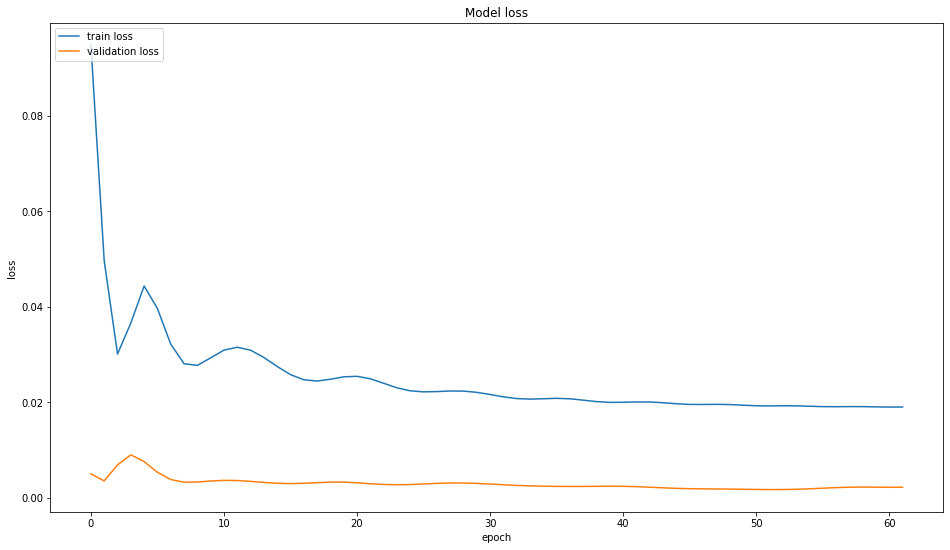

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [91]:
model_univariate = tf.keras.models.load_model(model_univariate_path)

In [92]:
X_test_rs = X_test.reshape(X_test.shape[0], WINDOW_SIZE, 1)

y_predict = model_univariate.predict(X_test_rs)

y_predict = scaler.inverse_transform(y_predict)

y_test_rs = y_test.reshape(-1,1)
y_true = scaler.inverse_transform(y_test_rs)

y_predict_univariate_lstm = y_predict.squeeze()
y_true_univariate_lstm = y_true.squeeze()

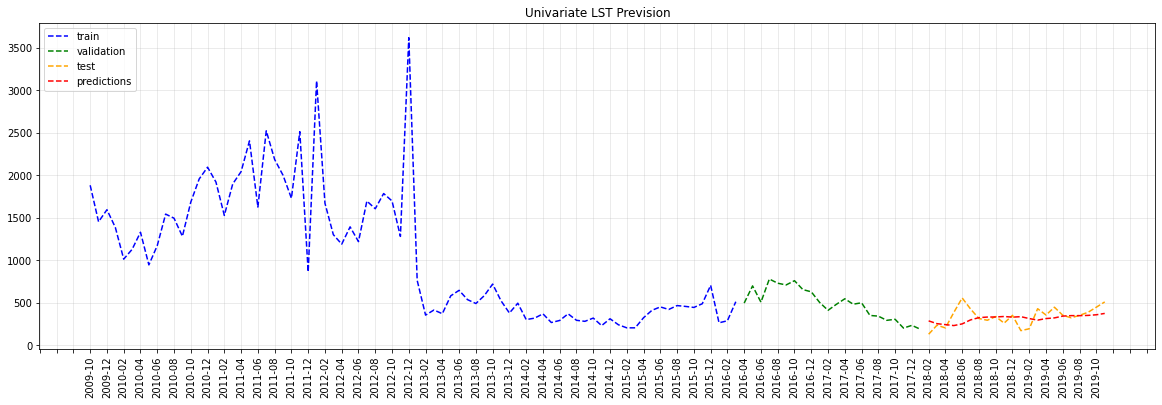

In [93]:
y_train_rs = y_train.reshape(-1,1)
y_train_rs = scaler.inverse_transform(y_train_rs)
y_train_rs = y_train_rs.squeeze()

y_valid_rs = y_valid.reshape(-1,1)
y_valid_rs = scaler.inverse_transform(y_valid_rs)
y_valid_rs = y_valid_rs.squeeze()

len_train = len(y_train_rs)
len_with_valid = len(y_train_rs) + len(y_valid_rs)
len_with_test = len(y_train) + len(y_valid) + len(y_test)

plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len_train], y_train_rs, 'b--', label="train")
plt.plot(desembolso_time[len_train:len_with_valid], y_valid_rs, color='green', linestyle="--", label="validation")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_true_univariate_lstm, color='orange', linestyle='--', label="test")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_predict_univariate_lstm, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Univariate LST Prevision")
plt.grid(alpha=0.3);

In [161]:
y_true

array([[0.        ],
       [0.03053972],
       [0.02119295],
       [0.07333688],
       [0.12236084],
       [0.0849965 ],
       [0.05290877],
       [0.04712102],
       [0.05958559],
       [0.0373751 ],
       [0.06377636],
       [0.01212547],
       [0.01840494],
       [0.08600916],
       [0.0647226 ],
       [0.09111268],
       [0.0639237 ],
       [0.05537412],
       [0.0637601 ],
       [0.07381278],
       [0.09115141],
       [0.10897051]])

In [160]:
y_predict_univariate_lstm

array([0.12494645, 0.12470386, 0.12469054, 0.12425758, 0.12407469,
       0.12426187, 0.12421622, 0.12377393, 0.12329822, 0.12295398,
       0.12229259, 0.12130764, 0.12094557, 0.12049697, 0.12003214,
       0.1193881 , 0.1184402 , 0.11773716, 0.11621802, 0.11491969,
       0.11379337, 0.11273589], dtype=float32)

In [94]:
univariate_lstm_mse = mean_squared_error(y_true, y_predict_univariate_lstm, squared=True)
univariate_lstm_mae = mean_absolute_error(y_true, y_predict_univariate_lstm)
univariate_lstm_r2 = r2_score(y_true, y_predict_univariate_lstm)
print(f'Mean Squared Error: {univariate_lstm_mse} ')
print(f'Mean Absolute Error: {univariate_lstm_mae}')
print(f'R2 Score: {univariate_lstm_r2}')

Mean Squared Error: 12408.19463810766 
Mean Absolute Error: 83.58477522203478
R2 Score: -0.08433028797930042
